This notebook will build a similarity matrix (or [distance matrix](https://en.wikipedia.org/wiki/Distance_matrix)), in case you want to use it as an example. We'll use a basic feature: how much overlap is there in who various phone numbers contact?

In [8]:
# first, read in the data

import os
import csv

os.chdir('../data/')

records = []

with open('call_records.csv') as f:
    reader = csv.reader(f)
    for row in reader:
        records.append(row)

print(records[0]) # print the header
records = records[1:] # remove the header
print(records[0]) # print an example record

['time', 'cell', 'from', 'to']
['0', '186', '974-703-1399', '876-251-8837']


In [9]:
# for each number, compute how many of its top ten match every other number

all_numbers = list(set([r[2] for r in records]))

#all_numbers = list(all_numbers)[:100] # let's work with a subset for now

# first, compute all top tens
top_tens = {}
for uniq_number in all_numbers:
    recipients = [r[3] for r in records if r[2] == uniq_number]
    uniq_recipients = sorted(list(set(recipients)))
    freq = [recipients.count(x) for x in uniq_recipients]
    top_list = [x for (x,y) in sorted(zip(uniq_recipients, freq), key=lambda pair: pair[1], reverse=True)]
    # top_list is a list of strings, with the "top" (most contacted) first (i.e descending)
    top_tens[uniq_number] = top_list

In [10]:
# now that we have top ten lists for every number, let's compare them

def compute_topten_similarity(number, numbers):
    our_topten = top_tens[number][:10]
    similarity_list = []
    for other_number in numbers:
        # a dilemma - do we count it as a match if it appears at all on the top ten list,
        # or just in the same positon? or maybe within +/- two of the same position?
        # for now, just compute a union
        their_topten = top_tens[other_number][:10]
        overlap = len(set(our_topten) & set(their_topten)) / 10
        similarity_list.append(1.0 - overlap)
    return similarity_list

similarity_matrix = []
for uniq_number in all_numbers:
    row = compute_topten_similarity(uniq_number, all_numbers)
    similarity_matrix.append(row)
    
%store similarity_matrix

Stored 'similarity_matrix' (list)


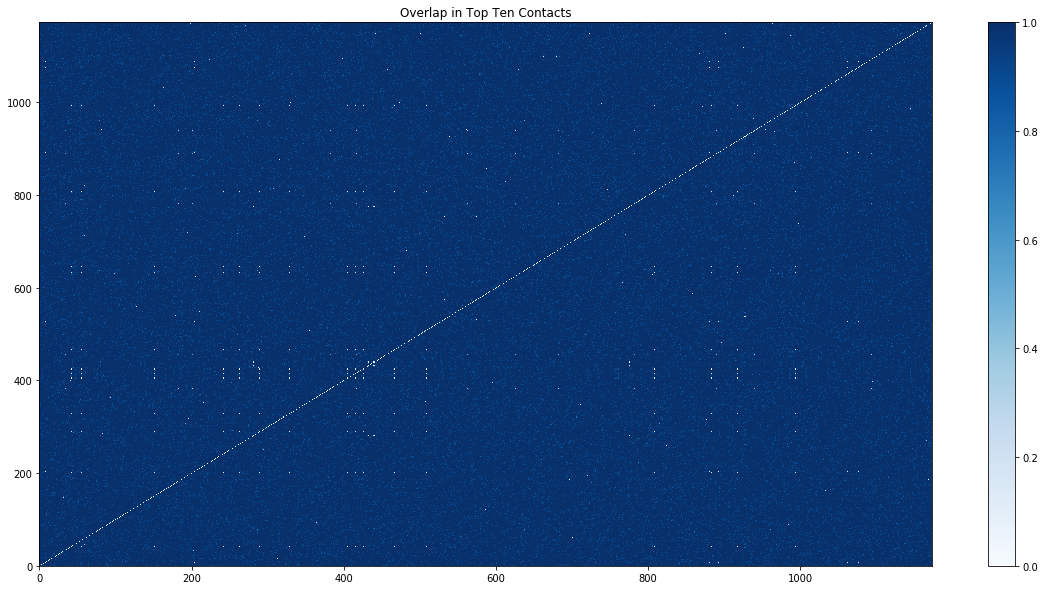

In [11]:
from matplotlib import pyplot as plt
cmap = plt.cm.Blues
heatmap = plt.pcolor(similarity_matrix, cmap=cmap)
plt.title("Overlap in Top Ten Contacts")
plt.colorbar()
fig = plt.gcf()
fig.set_size_inches(20,10)
plt.show()

In [12]:
from sklearn import cluster as clu
model = clu.AffinityPropagation(max_iter=1000, affinity='precomputed').fit(similarity_matrix)

In [13]:
cluster_centers_indices = model.cluster_centers_indices_
labels = model.labels_

n_clusters_ = len(cluster_centers_indices)

# we now have labels, and need to turn that into phone numbers
results = [[] for x in range(n_clusters_+1)]
for i,label in enumerate(labels):
    # for each label, grab the number it represents (all_numbers[i]) and
    # put it in the right cluster list (results[label])
    results[label].append(all_numbers[i])
  
for result in results:
    print(result)

['512-727-1573', '271-447-5324', '198-352-8055', '830-512-5435', '695-762-2041', '877-831-0628', '971-107-0973', '719-008-7263', '306-105-1033', '469-738-2283', '920-350-2966']
['184-635-3304', '595-650-1475', '201-044-6502', '888-615-9902', '737-753-3386', '385-842-4992', '555-776-7438', '175-861-1409', '265-858-4115', '931-387-6811', '617-670-3983', '761-638-1151', '195-656-9001', '335-870-7542']
['947-688-4676', '961-056-0227', '643-077-7878', '109-100-9987', '980-841-5675', '375-307-2693', '299-450-6365', '336-657-9184', '560-360-1134', '366-668-4323', '729-212-4321']
['746-280-0404', '259-745-0392', '238-236-2164', '387-255-9723', '304-547-9323', '515-307-4470', '106-576-2020', '557-032-2416', '892-343-4118', '174-382-1893', '597-840-8632', '789-764-2840', '453-654-4384', '136-631-1004']
['717-362-7073', '234-482-5866', '902-583-5601', '905-825-2557', '192-164-0770', '570-488-2874', '898-027-5106', '788-566-8200', '732-712-3535', '274-287-2118', '235-616-7350', '790-424-4894', '28

Theoretically, these clusters are of numbers which have high similarity to each other - in this case, that means they call each other a lot. Are they actually? Well, this isn't much data to go on (as you can see, the matrix graphed above is very dark, which is to say that most of the numbers aren't really related to each other, which is not super helpful), so the model is having a hard time... but I bet you could improve it. :)